In [48]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
n_samples=50000
n_features=20
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=5, n_redundant=2, n_repeated=0, n_classes=2,\
                           n_clusters_per_class=2, weights=[0.9,0.1], flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0,\
                           scale=1.0, shuffle=True, random_state=None)
y=np.array(y)
X=np.array(X)
y=np.reshape(y,(n_samples, 1))
X=np.reshape(X, (n_samples, n_features))
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)


In [49]:
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [50]:
#custom scoring function sklearn
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
def lift_index(y, probabilities):
    #rearrange probabilities and y in descending order
    probabilities = probabilities.ravel()
    combine = list(zip(y, probabilities))
    dtype = [('data', int), ('prob', float)]
    combine = np.array(combine,dtype=dtype)
    combine = np.sort(combine, order='prob') #sort according to probabilities
    ordered = np.sort(probabilities) #sort probabilities
    #divide into deciles
    deciles = pd.qcut(ordered, 10, duplicates='drop', labels=False) #creates array of digits from 1 to 10
    #sum of positive in each decile-if negative then zero and doesn't get taken into account
    sum_deciles = sum([((val+1)/10)*combine[num][0] for num, val in enumerate(deciles)])
    return sum_deciles/sum(y)
lift_index_score = make_scorer(lift_index, greater_is_better=True, needs_proba=True )



In [51]:

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.noise import AlphaDropout
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.initializers import lecun_uniform
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

from keras import backend as K
from keras import callbacks
from keras import layers
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.externals import joblib

def construct_model(layers=[50,50], activation='relu', b_init='random_uniform', k_init='random_uniform', dropout=.0,\
                    a_dropout=.0, optimizer='sgd', loss='binary_crossentropy', metrics='roc_auc_score',input_dim=20, output_dim=1, model_name='most'):
    """
    Helper to construct a Keras model based on dict of specs and input size

    Parameters
    ----------
    model_spec: dict
        Dict containing keys: arch, activation, dropout, optimizer, loss,
            w_reg, metrics
    input_dim: int
        Size of input dimension
    output_dim: int
        Size of input dimension

    Returns
    -------
    model: Compiled keras.models.Sequential

    """

    model = Sequential()

    for li, layer_size in enumerate(layers):
        # For input layer, add input dimension
        if li == 0:
            temp_input_dim = input_dim
            model.add(Dense(layer_size,
                            input_dim=temp_input_dim,
                            activation=activation,
                            bias_initializer=b_init,
                            kernel_initializer=k_init,
                            name='Input'))
        elif li < len(layers)-1:
            model.add(Dense(layer_size,
                            activation=activation,
                            bias_initializer=b_init,
                            kernel_initializer=k_init,
                            name='Layer_%i' % li))
        elif li == len(layers)-1:
            model.add(Dense( output_dim ,
                            activation='sigmoid',
                            bias_initializer=b_init,
                            kernel_initializer=k_init,
                            name='Layer_%i' % li))
            
        if dropout > 0. :
            if a_dropout == 0.:
                model.add(Dropout(dropout, name='Dropout_%i' % li))
        if a_dropout > 0.:
            model.add(Dropout(a_dropout, name='Dropout_%i' % li))
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metrics],
                 loss_weights=[2])
    #keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, save_best_only=True, \
    #                                write_graph=True, write_images=False)

    return model 
#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')
pipe = pipeline.Pipeline([
    ('rescale', preprocessing.StandardScaler()),
    ('nn', KerasClassifier(build_fn=construct_model, epochs=10, batch_size=128,
                           validation_split=0.2)) #, callbacks=[early_stopping]
])

In [54]:
#import data without any dummy variables or changes
from sklearn.model_selection import GridSearchCV

param_grid = {'nn__layers': [[100,100]],
              'nn__activation':['selu'],
              'nn__dropout': [0.],
              'nn__a_dropout': [0.2],
              'nn__k_init': ['lecun_normal'],
              'nn__b_init': ['lecun_normal'],
              'nn__optimizer':['adam'],
              'nn__metrics' : ['accuracy'],
              'nn__epochs':[10],
              'nn__batch_size':[32]}

#improve with article
grid = GridSearchCV(pipe,
                    param_grid,
                    return_train_score=True,
                    refit=True,
                    scoring='roc_auc',
                    verbose=15)

In [55]:
grid.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] nn__a_dropout=0.2, nn__activation=selu, nn__b_init=lecun_normal, nn__batch_size=32, nn__dropout=0.0, nn__epochs=10, nn__k_init=lecun_normal, nn__layers=[100, 100], nn__metrics=accuracy, nn__optimizer=adam 
Train on 17866 samples, validate on 4467 samples
Epoch 1/10
17866/17866 [==============================] - 2s 109us/step - loss: 2.0696 - acc: 0.7294 - val_loss: 0.5725 - val_acc: 0.9069

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s


Train on 17866 samples, validate on 4467 samples
Epoch 1/10
17866/17866 [==============================] - 2s 128us/step - loss: 1.0582 - acc: 0.9084 - val_loss: 0.4521 - val_acc: 0.9216

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.8s remaining:    0.0s


Train on 17867 samples, validate on 4467 samples
Epoch 1/10
17867/17867 [==============================] - 3s 151us/step - loss: 1.0776 - acc: 0.9076 - val_loss: 0.4400 - val_acc: 0.9185

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.1s finished


Train on 26800 samples, validate on 6700 samples
Epoch 1/10
26800/26800 [==============================] - 3s 101us/step - loss: 3.4318 - acc: 0.6879 - val_loss: 0.6045 - val_acc: 0.9082

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rescale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('nn', <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000020CFE8D0BE0>)]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'nn__layers': [[100, 100]], 'nn__activation': ['selu'], 'nn__dropout': [0.0], 'nn__a_dropout': [0.2], 'nn__k_init': ['lecun_normal'], 'nn__b_init': ['lecun_normal'], 'nn__optimizer': ['adam'], 'nn__metrics': ['accuracy'], 'nn__epochs': [10], 'nn__batch_size': [32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=15)

stratified generates random predictions by respecting the training set class distribution.
most_frequent always predicts the most frequent label in the training set.
prior always predicts the class that maximizes the class prior (like most_frequent`) and ``predict_proba returns the class prior.
uniform generates predictions uniformly at random.
constant always predicts a constant label that is provided by the user.

In [ ]:
from sklearn.dummy import DummyClassifier 

clf = DummyClassifier(strategy='most_frequent',random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)  

In [56]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [57]:
import matplotlib.pyplot as plt 
from matplotlib import cm
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

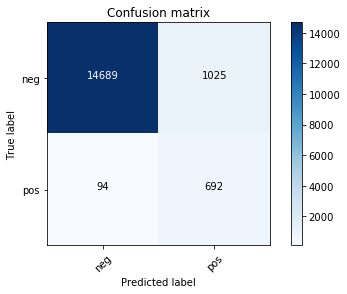

In [58]:
#and use helper functions above to show output
#visualization
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.utils import plot_model
#visualize best model
model=grid
n_classes = 2
model_name = 'dense'
plot_confusion_matrix(confusion_matrix(model.predict(X_test), y_test), ['neg', 'pos'])

Train on 11054 samples, validate on 5446 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


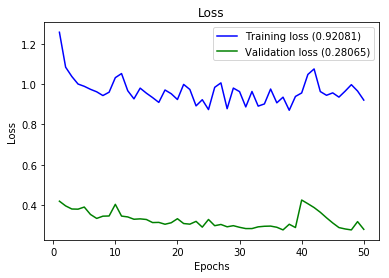

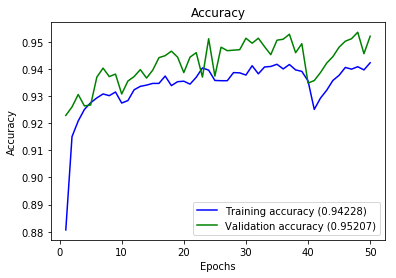

In [63]:
best = construct_model( layers=model.best_params_['nn__layers'],
              activation=model.best_params_['nn__activation'],
              b_init=model.best_params_['nn__b_init'],
              k_init=model.best_params_['nn__k_init'],
              dropout=model.best_params_['nn__dropout'],
              a_dropout=model.best_params_['nn__a_dropout'],
              optimizer=model.best_params_['nn__optimizer'],
              metrics=model.best_params_['nn__metrics'] )
plot_history(best.fit(X_test, y_test, validation_split=0.33, epochs=50, batch_size=10, verbose=10))
